In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


# Importing Libraries

In [ ]:
pip install wfdb

     |████████████████████████████████| 137 kB 4.8 MB/s 
     |████████████████████████████████| 11.2 MB 39.8 MB/s 
     |████████████████████████████████| 930 kB 40.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
pip install scipy

In [ ]:
pip install neurokit2

     |████████████████████████████████| 1.1 MB 5.5 MB/s 


In [ ]:
pip install tqdm

In [ ]:
pip install seaborn

In [ ]:
pip install prettytable

In [ ]:
pip install matplotlib==3.2

     |████████████████████████████████| 12.4 MB 5.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb 3.4.1 requires matplotlib>=3.3.4, but you have matplotlib 3.2.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# Defining Variables & Performing EDA

In [ ]:
databases = ['mitdb','incartdb']
path = r"/content/gdrive/My Drive/arrhythmia/"

invalid_beats  = ['!', '"', "'", '(', ')', '*', '+', '=', '@', 'D', 'T', '[', ']', '^', '`', 'p', 's', 't', 'u', 'x', '|', '~']
abnormal_beats = ['/', '?', 'A', 'B', 'E', 'F', 'J', 'L', 'Q', 'R', 'S', 'V', 'a', 'e', 'f', 'j', 'n', 'r']
normal_beats   = ['.', 'N']

In [ ]:
if False:
    print("Downloading databases & creating record files: ")
    for database in databases:
        print(f"\n{database}\n")
        wfdb.dl_database(database,f"{path}/databases/{database}",overwrite = False)
        list_of_records = sorted(wfdb.get_record_list(database),key = len) 
        record_file = open(f"{path}/databases/{database}/RECORDS.txt", "w")
        for record in list_of_records:
            record_file.write(record + "\n")
        record_file.close()

In [ ]:
import pandas as pd, numpy as np, wfdb
df = pd.DataFrame()

for database in databases:
  for pt in sorted(wfdb.get_record_list(database),key = len):
    record = wfdb.rdrecord(f"{path}/databases/{database}/{pt}")
    annotation = wfdb.rdann(f"{path}/databases/{database}/{pt}", 'atr')
    symbol, sample = annotation.symbol, annotation.sample
    
    values, counts = np.unique(symbol, return_counts = True)
    
    subdf = pd.DataFrame({'database':database, 'frequency':[record.fs] * len(counts), 
                          'symbol':values, 'counts':counts, 'pt':[pt] * len(counts)})
    df = pd.concat([df, subdf], axis = 0)

df.index = [i for i in range(1, len(df.values) + 1)]

In [ ]:
df.groupby(['database','frequency','symbol']).counts.sum()

database  frequency  symbol
incartdb  257        +             12
                     A           1944
                     B              1
                     F            219
                     N         150410
                     Q              6
                     R           3174
                     S             16
                     V          20013
                     j             92
                     n             32
mitdb     360        !            472
                     "            437
                     +           1291
                     /           7028
                     A           2546
                     E            106
                     F            803
                     J             83
                     L           8075
                     N          75052
                     Q             33
                     R           7259
                     S              2
                     V           7130
                     [

In [ ]:
df['category'] = "invalid"
df.loc[df.symbol.isin(normal_beats),'category'] = "valid"
df.loc[df.symbol.isin(abnormal_beats), 'category'] = "abnormal"

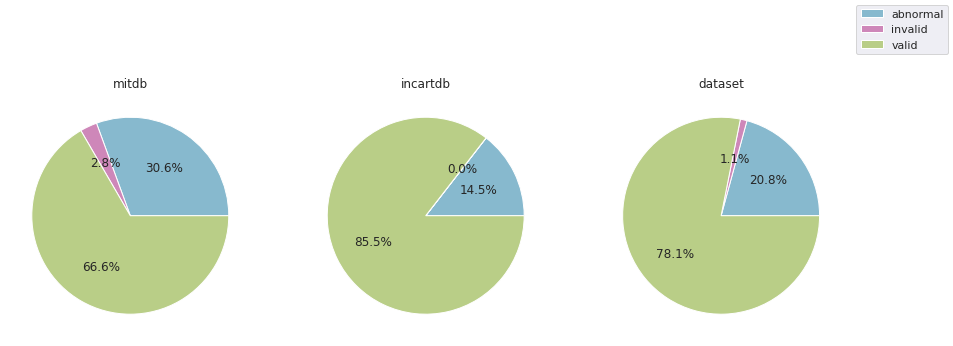

In [ ]:
import matplotlib.pyplot as plt, seaborn as sns
colours = ["#87b9ce", "#ce87b9", "#b9ce87"]
plt.rcParams["figure.figsize"] = (15, 6)
sns.set()

edadatabase, plotdatabase = plt.subplots(1, 3)

for idx, database in enumerate(databases):
  _ = plotdatabase[idx].pie(df.loc[df['database'].isin([f"{database}"])].groupby('category').counts.sum(), autopct = '%.1f%%', colors = colours)
  plotdatabase[idx].set_title(database)

_ = plotdatabase[-1].pie(df.groupby('category').counts.sum(), autopct = '%.1f%%', colors = colours)
plotdatabase[-1].set_title("dataset")

_ = edadatabase.legend(['abnormal','invalid','valid'])

In [ ]:
print(df.groupby(['category']).counts.sum())
print()
print(df.groupby(['database','category']).counts.sum())

category
abnormal     59939
invalid       3165
valid       225462
Name: counts, dtype: int64

database  category
incartdb  abnormal     25497
          invalid         12
          valid       150410
mitdb     abnormal     34442
          invalid       3153
          valid        75052
Name: counts, dtype: int64


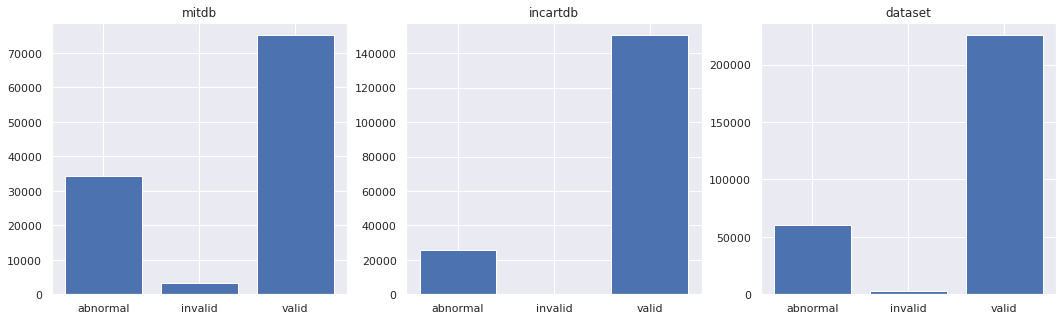

In [ ]:
import matplotlib.pyplot as plt, seaborn as sns
colours = ["#87b9ce", "#ce87b9", "#b9ce87"]
plt.rcParams["figure.figsize"] = (18, 5)
sns.set()

edadatabase, plotdatabase = plt.subplots(1, 3)

for idx, database in enumerate(databases):
  height = df.loc[df['database'].isin([f"{database}"])].groupby('category').counts.sum().to_numpy()
  _ = plotdatabase[idx].bar(x = ['abnormal','invalid','valid'] , height = height)
  plotdatabase[idx].set_title(database)

heights = df.groupby('category').counts.sum().to_numpy()
_ = plotdatabase[-1].bar(x = ['abnormal','invalid','valid'] , height = heights)
_ = plotdatabase[-1].set_title("dataset")

# Preprocess Signals & Create Dataset

In [ ]:
import wfdb, numpy as np

'''function resamples signal & annotation to target frequency'''
def resamplerecord(signal, annotation, frequency, targetfrequency):
  from wfdb import processing
  ratio = targetfrequency / frequency
  if ratio == 1.0:
    return signal, annotation 

  newsignal = []
  channels = np.shape(signal)[1]
  for channel in range(channels):
    ns, _ = wfdb.processing.resample_sig(signal[:,channel], frequency, targetfrequency)
    newsignal.append(ns)
  annotation.sample = (ratio * annotation.sample).astype(np.int64)

  return np.column_stack(newsignal), annotation

In [ ]:
from scipy.signal import butter, filtfilt

'''function filters signal using a bandpass filter'''
def filtersignal(signal, order, cutoff, sample_rate):
  nyquist_rate = 0.5 * sample_rate
  lowcut, highcut = cutoff[0] / nyquist_rate, cutoff[1] / nyquist_rate
  b, a = butter(order, [lowcut,highcut], btype = 'band')

  newsignal = []
  channels = np.shape(signal)[1]
  for channel in range(channels):
    ns = filtfilt(b, a, signal[:,channel])
    newsignal.append(ns)

  return np.column_stack(newsignal)

In [ ]:
'''function returns sample & symbol for each beat'''
def sliceannotation(annotation, start, end):
  end = end or annotation.sample[-1]
  indices = np.intersect1d(np.where(annotation.sample >= start), np.where(annotation.sample <= end))
  symbols = [annotation.symbol[i] for i in indices]
  samples = [annotation.sample[i] for i in indices]
  symbol = symbols[0] if len(symbols) == 1 else None
  return np.array(samples), symbol

In [ ]:
import pandas as pd, numpy as np, neurokit2 as nk, wfdb
from tqdm.notebook import tqdm_notebook
from sklearn.preprocessing import StandardScaler

subjectmap = pd.DataFrame()
sequences = []
labels = []
np.random.seed(42)

for database in databases:
    RECORDS = sorted(wfdb.get_record_list(database),key = len)
    for pt in tqdm_notebook(RECORDS, desc = f"{database}"):
      record = wfdb.rdrecord(f"{path}/databases/{database}/{pt}")
      annotation = wfdb.rdann(f"{path}/databases/{database}/{pt}", extension = 'atr')
      
      frequency = record.fs
      record.p_signal, annotation = resamplerecord(record.p_signal, annotation, frequency, 360)
      record.p_signal = filtersignal(record.p_signal, order = 5, cutoff = [0.5,15], sample_rate = 360)

      scaler = StandardScaler()
      record.p_signal = scaler.fit_transform(record.p_signal)
      
      _, rpeaks = nk.ecg_peaks(record.p_signal[:,0], sampling_rate = 360)
      rpeaks = rpeaks['ECG_R_Peaks'].tolist()

      window = 256
      for i, sample in enumerate(rpeaks):
          label, sequence = None, np.array([])
          start, end = sample - window // 2, sample + window // 2
          
          if 0 < start < end < record.p_signal.shape[0]:
            samples, symbol = sliceannotation(annotation, start, end)
            label  = 1 if symbol in abnormal_beats else 0 if symbol in normal_beats else None
            sequence = record.p_signal[start:end, 0]
            sequence.reshape(1, -1, 1)

            if (label is not None and sequence.size > 0) and (symbol != "N" or np.random.random() > 0.75):
              sequences.append(sequence)
              labels.append(label)
              subjectsubmap = pd.DataFrame({'database':database,'patient':pt, 'start':[start], 'end':[end], 'symbol':symbol, 'category':label})
              subjectmap = pd.concat([subjectmap, subjectsubmap], axis = 0)

mitdb:   0%|          | 0/48 [00:00<?, ?it/s]

incartdb:   0%|          | 0/75 [00:00<?, ?it/s]

In [ ]:
x, y = np.vstack(sequences), np.vstack(labels)
x.shape, y.shape

((110130, 256), (110130, 1))

In [ ]:
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

In [ ]:
print(subjectmap['category'].value_counts().sort_index())
print()
print(subjectmap.groupby(['database']).category.value_counts().sort_index())

0    54975
1    55155
Name: category, dtype: int64

database  category
incartdb  0           36264
          1           22232
mitdb     0           18711
          1           32923
Name: category, dtype: int64


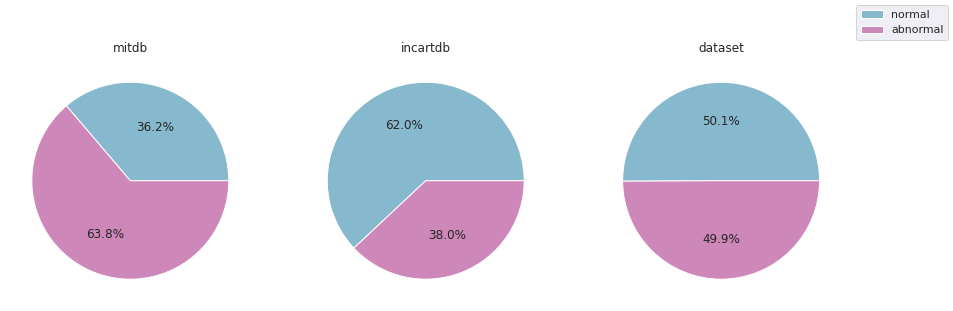

In [ ]:
import matplotlib.pyplot as plt, seaborn as sns
colours = ["#87b9ce", "#ce87b9", "#b9ce87"]
plt.rcParams["figure.figsize"] = (15, 5)
sns.set()

edadataset, plotdataset = plt.subplots(1, 3)

for idx, database in enumerate(databases):
  _ = plotdataset[idx].pie(subjectmap.loc[subjectmap['database'].isin([f"{database}"])]['category'].value_counts().sort_index(), autopct = '%.1f%%', 
                           colors = colours)
  plotdataset[idx].set_title(database)

_ = plotdataset[-1].pie(subjectmap['category'].value_counts(), autopct = '%.1f%%', colors = colours)
_ = plotdataset[-1].set_title("dataset")

edadataset.legend(['normal','abnormal'])

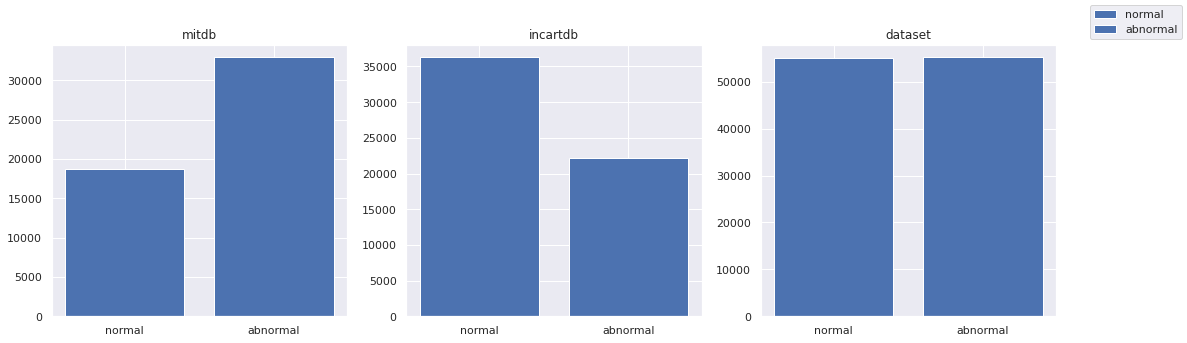

In [ ]:
import matplotlib.pyplot as plt, seaborn as sns
colours = ["#87b9ce", "#ce87b9", "#b9ce87"]
plt.rcParams["figure.figsize"] = (18, 5)
sns.set()

edadataset, plotdataset = plt.subplots(1, 3)

for idx, database in enumerate(databases):
  height = subjectmap.loc[subjectmap['database'].isin([f"{database}"])]['category'].value_counts().sort_index().to_numpy()
  _ = plotdataset[idx].bar(x = ['normal', 'abnormal'] , height = height)
  plotdataset[idx].set_title(database)

heights = subjectmap['category'].value_counts().sort_index().to_numpy()
_ = plotdataset[-1].bar(x =  ['normal', 'abnormal'] , height = heights)
_ = plotdataset[-1].set_title("dataset")

edadataset.legend(['normal','abnormal'])

# Split Dataset & Create Model

In [ ]:
from keras.callbacks import LearningRateScheduler,EarlyStopping
import math

def schedule(epoch):
   lr, base, step = 0.001, 0.5, 5
   return lr * math.pow(base, (epoch) // step)

lrcallback = LearningRateScheduler(schedule, verbose = 0)
escallback = EarlyStopping(monitor="val_accuracy", patience = 7)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from prettytable import PrettyTable

modelmetrics = PrettyTable()
modelmetrics.field_names = ["fold", "train or test", "accuracy", "recall", "precision", "F1 score", "specificity"]
meanprecision = []
meanrecall = []

def getmetrics(fold, trainortest, y_actual, predictions):
  threshold = (sum(y_actual) / len(y_actual))[0]

  accuracy = round(accuracy_score(y_actual, (predictions > threshold)), 3)
  recall = round(recall_score(y_actual, (predictions > threshold)), 3)
  precision = round(precision_score(y_actual, (predictions > threshold)), 3)
  f1score = round((2 * precision * recall) / (precision + recall), 3)
  specificity = sum((predictions < threshold) & (y_actual == 0)) / sum(y_actual == 0)
  
  modelmetrics.add_row([fold, trainortest, accuracy, recall, precision, f1score, specificity[0]])
  
  if trainortest == "test":
    meanprecision.append(precision)
    meanrecall.append(recall)

## Splitting on Samples

In [ ]:
from sklearn.model_selection import StratifiedKFold

splits = StratifiedKFold(n_splits = 10, shuffle = True)
X = subjectmap[['start', 'end', 'patient']]
Y = subjectmap['category']

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, AveragePooling1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization, ReLU
from keras import regularizers
from tensorflow.keras.optimizers import Adam
import warnings

warnings.filterwarnings('ignore')
meanaccuracy = []
meanloss = []
count = 1

for trainindices, testindices in splits.split(X, Y):
    xtrain, ytrain, xtest, ytest = X.iloc[trainindices], Y.iloc[trainindices], X.iloc[testindices], Y.iloc[testindices]
    x_train, y_train = np.array([x[i,:,:] for i in trainindices]), np.array([y[i] for i in trainindices])
    x_test,  y_test  = np.array([x[i,:,:] for i in testindices]),  np.array([y[i] for i in testindices])

    print("\nfold ", count, "\n")

    nfeatures = 1
    model = Sequential()
    model.add(Conv1D(filters = 10, kernel_size = 4, input_shape = (x_train.shape[1], nfeatures), kernel_regularizer = regularizers.l2(1e-4), bias_regularizer = regularizers.l2(1e-4), \
                    activity_regularizer = regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(AveragePooling1D(pool_size = 2, strides = 2))

    model.add(Conv1D(filters = 15, kernel_size = 8))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.5))
    model.add(AveragePooling1D(pool_size = 2, strides = 2))

    model.add(Conv1D(filters = 20, kernel_size = 8, kernel_regularizer = regularizers.l2(1e-4), bias_regularizer = regularizers.l2(1e-4), activity_regularizer = regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(AveragePooling1D(pool_size = 2, strides = 2))

    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer = Adam(1e-3), metrics = ['accuracy'])
    history = model.fit(x_train, y_train, batch_size = 128, epochs = 20, verbose = 1, validation_data = (x_test, y_test), callbacks = [lrcallback, escallback])

    meanaccuracy.append((history.history['accuracy'][-1], history.history['val_accuracy'][-1]))
    meanloss.append((history.history['loss'][-1], history.history['val_loss'][-1]))
    
    getmetrics(count, "train", y_train, model.predict(x_train, verbose = 0))
    getmetrics(count, "test",  y_test,  model.predict(x_test, verbose = 0))

    count = count + 1


fold  1 

Epoch 1/20
775/775 [==============================] - 41s 49ms/step - loss: 0.2773 - accuracy: 0.9028 - val_loss: 0.2171 - val_accuracy: 0.9304 - lr: 0.0010
Epoch 2/20
775/775 [==============================] - 41s 52ms/step - loss: 0.2041 - accuracy: 0.9286 - val_loss: 0.1883 - val_accuracy: 0.9373 - lr: 0.0010
Epoch 3/20
775/775 [==============================] - 41s 53ms/step - loss: 0.1845 - accuracy: 0.9363 - val_loss: 0.1772 - val_accuracy: 0.9396 - lr: 0.0010
Epoch 4/20
775/775 [==============================] - 39s 51ms/step - loss: 0.1755 - accuracy: 0.9400 - val_loss: 0.1658 - val_accuracy: 0.9445 - lr: 0.0010
Epoch 5/20
775/775 [==============================] - 40s 51ms/step - loss: 0.1685 - accuracy: 0.9423 - val_loss: 0.1683 - val_accuracy: 0.9439 - lr: 0.0010
Epoch 6/20
775/775 [==============================] - 41s 53ms/step - loss: 0.1581 - accuracy: 0.9466 - val_loss: 0.1542 - val_accuracy: 0.9493 - lr: 5.0000e-04
Epoch 7/20
775/775 [=======================

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 253, 10)           50        
                                                                 
 batch_normalization_27 (Bat  (None, 253, 10)          40        
 chNormalization)                                                
                                                                 
 re_lu_27 (ReLU)             (None, 253, 10)           0         
                                                                 
 average_pooling1d_27 (Avera  (None, 126, 10)          0         
 gePooling1D)                                                    
                                                                 
 conv1d_28 (Conv1D)          (None, 119, 15)           1215      
                                                                 
 batch_normalization_28 (Bat  (None, 119, 15)         

In [ ]:
print("performance metrics for training & testing data\n")
print(modelmetrics)

accuracy, validationaccuracy = np.mean(meanaccuracy, axis = 0)
loss, validationloss = np.mean(meanloss, axis = 0)

print("average accuracy: ", accuracy)
print("average validation accuracy: ", validationaccuracy)
print("average loss: ", loss)
print("average validation loss: ", validationloss)
print("average recall:", np.mean(meanrecall, axis = 0))
print("average precision:", np.mean(meanprecision, axis = 0))

performance metrics for training & testing data

+------+---------------+----------+--------+-----------+----------+--------------------+
| fold | train or test | accuracy | recall | precision | F1 score |    specificity     |
+------+---------------+----------+--------+-----------+----------+--------------------+
|  1   |     train     |  0.959   | 0.945  |   0.972   |  0.958   | 0.9723710006669766 |
|  1   |      test     |  0.955   | 0.937  |   0.971   |  0.954   | 0.9721716987995634 |
|  2   |     train     |  0.957   | 0.939  |   0.973   |  0.956   | 0.9743315075691735 |
|  2   |      test     |  0.955   | 0.943  |   0.968   |  0.955   | 0.9683521280465623 |
|  3   |     train     |  0.959   | 0.942  |   0.975   |  0.958   | 0.9754027123714049 |
|  3   |      test     |  0.955   | 0.936  |   0.974   |  0.955   | 0.9747180793015642 |
|  4   |     train     |  0.957   | 0.939  |   0.975   |  0.957   | 0.9757665177759363 |
|  4   |      test     |  0.955   | 0.938  |   0.971   |  0.9

## Splitting on Patients

In [ ]:
modelmetrics = PrettyTable()
modelmetrics.field_names = ["fold", "train or test", "accuracy", "recall", "precision", "F1 score", "specificity"] 
meanprecision = []
meanrecall = []

In [ ]:
import random

groups = [df for _, df in subjectmap.groupby(['database','patient'])]
random.Random(36).shuffle(groups)
subjectmap = pd.concat(groups)

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold

splits = StratifiedGroupKFold(n_splits = 10)
X = subjectmap[['start', 'end', 'patient']]
Y = subjectmap['category']
GROUPS = subjectmap['patient']

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, AveragePooling1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization, ReLU
from keras import regularizers
from tensorflow.keras.optimizers import Adam
import warnings

warnings.filterwarnings('ignore')
meanaccuracy = []
meanloss = []
count = 1

for trainindices, testindices in splits.split(X, Y, GROUPS):
    xtrain, ytrain, xtest, ytest = X.iloc[trainindices], Y.iloc[trainindices], X.iloc[testindices], Y.iloc[testindices]
    x_train, y_train = np.array([x[i,:,:] for i in trainindices]), np.array([y[i] for i in trainindices])
    x_test,  y_test  = np.array([x[i,:,:] for i in testindices]),  np.array([y[i] for i in testindices])

    print("\nfold ", count, "\n")

    nfeatures = 1
    model = Sequential()
    model.add(Conv1D(filters = 10, kernel_size = 4, input_shape = (x_train.shape[1], nfeatures), kernel_regularizer = regularizers.l2(1e-4),
                     bias_regularizer = regularizers.l2(1e-4), activity_regularizer = regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(AveragePooling1D(pool_size = 2, strides = 2))

    model.add(Conv1D(filters = 15, kernel_size = 8))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.5))
    model.add(AveragePooling1D(pool_size = 2, strides = 2))

    model.add(Conv1D(filters = 20, kernel_size = 8, kernel_regularizer = regularizers.l2(1e-4), bias_regularizer = regularizers.l2(1e-4),
                     activity_regularizer = regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(AveragePooling1D(pool_size = 2, strides = 2))

    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer = Adam(1e-3), metrics = ['accuracy'])
    history = model.fit(x_train, y_train, batch_size = 128, epochs = 20, verbose = 1, validation_data = (x_test, y_test), callbacks = [lrcallback, escallback])

    meanaccuracy.append((history.history['accuracy'][-1], history.history['val_accuracy'][-1]))
    meanloss.append((history.history['loss'][-1], history.history['val_loss'][-1]))
    
    getmetrics(count, "train", y_train, model.predict(x_train, verbose = 0))
    getmetrics(count, "test",  y_test,  model.predict(x_test, verbose = 0))

    count = count + 1


fold  1 

Epoch 1/20
777/777 [==============================] - 40s 50ms/step - loss: 0.3020 - accuracy: 0.8982 - val_loss: 0.2774 - val_accuracy: 0.8664 - lr: 0.0010
Epoch 2/20
777/777 [==============================] - 37s 47ms/step - loss: 0.2143 - accuracy: 0.9264 - val_loss: 0.2823 - val_accuracy: 0.9026 - lr: 0.0010
Epoch 3/20
777/777 [==============================] - 37s 48ms/step - loss: 0.1935 - accuracy: 0.9336 - val_loss: 0.2498 - val_accuracy: 0.9168 - lr: 0.0010
Epoch 4/20
777/777 [==============================] - 37s 48ms/step - loss: 0.1797 - accuracy: 0.9377 - val_loss: 0.3075 - val_accuracy: 0.8464 - lr: 0.0010
Epoch 5/20
777/777 [==============================] - 37s 48ms/step - loss: 0.1723 - accuracy: 0.9407 - val_loss: 0.2517 - val_accuracy: 0.9115 - lr: 0.0010
Epoch 6/20
777/777 [==============================] - 37s 48ms/step - loss: 0.1593 - accuracy: 0.9461 - val_loss: 0.2268 - val_accuracy: 0.9146 - lr: 5.0000e-04
Epoch 7/20
777/777 [=======================

In [ ]:
print("performance metrics for training & testing data\n")
print(modelmetrics)

accuracy, validationaccuracy = np.mean(meanaccuracy, axis = 0)
loss, validationloss = np.mean(meanloss, axis = 0)

print("average accuracy: ", accuracy)
print("average validation accuracy: ", validationaccuracy)
print("average loss: ", loss)
print("average validation loss: ", validationloss)
print("average recall:", np.mean(meanrecall, axis = 0))
print("average precision:", np.mean(meanprecision, axis = 0))

performance metrics for training & testing data

+------+---------------+----------+--------+-----------+----------+--------------------+
| fold | train or test | accuracy | recall | precision | F1 score |    specificity     |
+------+---------------+----------+--------+-----------+----------+--------------------+
|  1   |     train     |  0.959   | 0.943  |   0.977   |   0.96   | 0.9763962765957447 |
|  1   |      test     |  0.917   | 0.935  |   0.849   |   0.89   | 0.9059442091426902 |
|  2   |     train     |  0.954   | 0.945  |   0.961   |  0.953   | 0.9628589510323551 |
|  2   |      test     |  0.941   | 0.931  |   0.969   |   0.95   | 0.9555656313761052 |
|  3   |     train     |  0.957   | 0.945  |   0.968   |  0.956   | 0.9695527692763353 |
|  3   |      test     |  0.939   | 0.943  |   0.955   |  0.949   | 0.9327944572748268 |
|  4   |     train     |  0.962   | 0.944  |   0.981   |  0.962   | 0.9803307259787953 |
|  4   |      test     |  0.896   | 0.793  |   0.902   |  0.8

In [ ]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_57 (Conv1D)          (None, 253, 10)           50        
                                                                 
 batch_normalization_57 (Bat  (None, 253, 10)          40        
 chNormalization)                                                
                                                                 
 re_lu_57 (ReLU)             (None, 253, 10)           0         
                                                                 
 average_pooling1d_57 (Avera  (None, 126, 10)          0         
 gePooling1D)                                                    
                                                                 
 conv1d_58 (Conv1D)          (None, 119, 15)           1215      
                                                                 
 batch_normalization_58 (Bat  (None, 119, 15)        